## **Forecasting Average Length of Stay (ALOS) in U.S. Hospitals.**
---

### **Project Overview**

**The primary aim of this project is to analyze the Average Length of Stay (ALOS) in hospitals and forecast future trends. By leveraging the historical data of inpatient days ([Total Inpatient Days for Hospitals](https://fred.stlouisfed.org/series/INPAT622ALLEST176QNSA)) and hospital discharges ([Total Discharges for Hospitals](https://fred.stlouisfed.org/series/DISC622ALLEST176QNSA)), this project seeks to understand trends in future ALOS trend, in order to make informed decisions regarding capacity planning, resource allocation, and operational efficiency in healthcare settings**

#### **Import the required dependencies**

In [97]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import requests
import json
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

### **Data Extraction**
---

#### **Lets buid a function to call the FRED API to extract 'Total Inpatient Days for Hospitals' and 'Total Discharges for Hospitals' dataset**

In [98]:
load_dotenv()
def get_fred_series(series_id, token=None):

    api_token = token or os.getenv('FRED_API_KEY')

    if not api_token:
        raise Exception("API key required. Provide token parameter or set FRED_API_KEY environment variable")

    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_token}&file_type=json"

    response = requests.get(url)

    if response.status_code == 200:
        jsondata = response.json()
        observations = jsondata.get('observations', [])
        data = pd.DataFrame(observations)

        if not data.empty:
            print("Available columns:", data.columns.tolist())
            return data
        else:
            raise Exception("No data returned for the given series ID")
    else:
        raise Exception(f"API request failed with status code: {response.status_code}")

#### **Now lets call the function and extract the dataset**

In [99]:
from google.colab import userdata

data=get_fred_series("DISC622ALLEST176QNSA", token=userdata.get('fred_api'))
data1=get_fred_series("INPAT622ALLEST176QNSA", token=userdata.get('fred_api'))

Available columns: ['realtime_start', 'realtime_end', 'date', 'value']
Available columns: ['realtime_start', 'realtime_end', 'date', 'value']


#### **Lets drop those column which are not necessary and transform as needed**

In [100]:
data = data.drop(['realtime_start', 'realtime_end'], axis=1)
file1 = data.rename(columns={'value': 'total_discharge'})
file1['total_discharge'] = pd.to_numeric(file1['total_discharge'], errors='coerce')
file1['date'] = pd.to_datetime(file1['date'])

In [101]:
data1 = data1.drop(['realtime_start', 'realtime_end'], axis=1)
file2 = data1.rename(columns={'value': 'total_inpatient_days'})
file2['total_inpatient_days'] = pd.to_numeric(file2['total_inpatient_days'], errors='coerce')
file2['date'] = pd.to_datetime(file2['date'])

### **Data Cleaning & Preprocessing**
---

#### **Explore the dataset and check for null values and duplicates**

In [102]:
print(file1.head())
print(file1.info())
print(file1.isna().sum())
print(file1.duplicated().sum())

        date  total_discharge
0 2004-10-01           9767.0
1 2005-01-01          10163.0
2 2005-04-01           9864.0
3 2005-07-01           9751.0
4 2005-10-01           9576.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             82 non-null     datetime64[ns]
 1   total_discharge  82 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 KB
None
date               0
total_discharge    0
dtype: int64
0


In [103]:
print(file2.head())
print(file2.info())
print(file2.isna().sum())
print(file2.duplicated().sum())

        date  total_inpatient_days
0 2004-10-01               53367.0
1 2005-01-01               56183.0
2 2005-04-01               53105.0
3 2005-07-01               52641.0
4 2005-10-01               52156.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  82 non-null     datetime64[ns]
 1   total_inpatient_days  82 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 KB
None
date                    0
total_inpatient_days    0
dtype: int64
0


#### **Now, to calculate ALOS, we can simply divide 'total_inpatient_days' by 'total_discharge',** $$\text{ALOS} = \frac{\text{total_inpatient_days}}{\text{total_discharge}}$$
**So, lets merge both the dataset into one and perform the calculation as needed**

In [104]:
file3=pd.merge(file1, file2, on='date').set_index('date')
file3.head()

,total_discharge,total_inpatient_days
date,,
2004-10-01,9767.0,53367.0
2005-01-01,10163.0,56183.0
2005-04-01,9864.0,53105.0
2005-07-01,9751.0,52641.0
2005-10-01,9576.0,52156.0


In [105]:
print(file3.head())
print(file3.info())
print(file3.isna().sum())
print(file3.duplicated().sum())

            total_discharge  total_inpatient_days
date                                             
2004-10-01           9767.0               53367.0
2005-01-01          10163.0               56183.0
2005-04-01           9864.0               53105.0
2005-07-01           9751.0               52641.0
2005-10-01           9576.0               52156.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82 entries, 2004-10-01 to 2025-01-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_discharge       82 non-null     float64
 1   total_inpatient_days  82 non-null     float64
dtypes: float64(2)
memory usage: 1.9 KB
None
total_discharge         0
total_inpatient_days    0
dtype: int64
0


In [106]:
file3['ALOS']=file3['total_inpatient_days']/file3['total_discharge']
file3.head()

,total_discharge,total_inpatient_days,ALOS
date,,,
2004-10-01,9767.0,53367.0,5.464011
2005-01-01,10163.0,56183.0,5.528190
2005-04-01,9864.0,53105.0,5.383719
2005-07-01,9751.0,52641.0,5.398523
2005-10-01,9576.0,52156.0,5.446533


In [107]:
df=file3[['ALOS']]
df.head()

,ALOS
date,
2004-10-01,5.464011
2005-01-01,5.528190
2005-04-01,5.383719
2005-07-01,5.398523
2005-10-01,5.446533


In [108]:
print(df.head())
print(df.info())
print(df.isna().sum())
print(df.duplicated().sum())

                ALOS
date                
2004-10-01  5.464011
2005-01-01  5.528190
2005-04-01  5.383719
2005-07-01  5.398523
2005-10-01  5.446533
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82 entries, 2004-10-01 to 2025-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ALOS    82 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB
None
ALOS    0
dtype: int64
0


#### **Now, to keep things clean and simple lets split the dataset into train and test set**

In [109]:
cut_off_date=pd.to_datetime('2024-01-01')
tr_df=df[df.index<cut_off_date]
ts_df=df[df.index>=cut_off_date]

In [110]:
print(tr_df.head())
print(tr_df.info())
print(ts_df.head())
print(ts_df.info())

                ALOS
date                
2004-10-01  5.464011
2005-01-01  5.528190
2005-04-01  5.383719
2005-07-01  5.398523
2005-10-01  5.446533
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 77 entries, 2004-10-01 to 2023-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ALOS    77 non-null     float64
dtypes: float64(1)
memory usage: 1.2 KB
None
                ALOS
date                
2024-01-01  6.189120
2024-04-01  6.018057
2024-07-01  5.996917
2024-10-01  6.019806
2025-01-01  6.091646
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5 entries, 2024-01-01 to 2025-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ALOS    5 non-null      float64
dtypes: float64(1)
memory usage: 80.0 bytes
None


### **Time Series EDA**
---

#### **Lets plot the dataset and try to identify if our dataset shows any presence of seasonal and trend component**

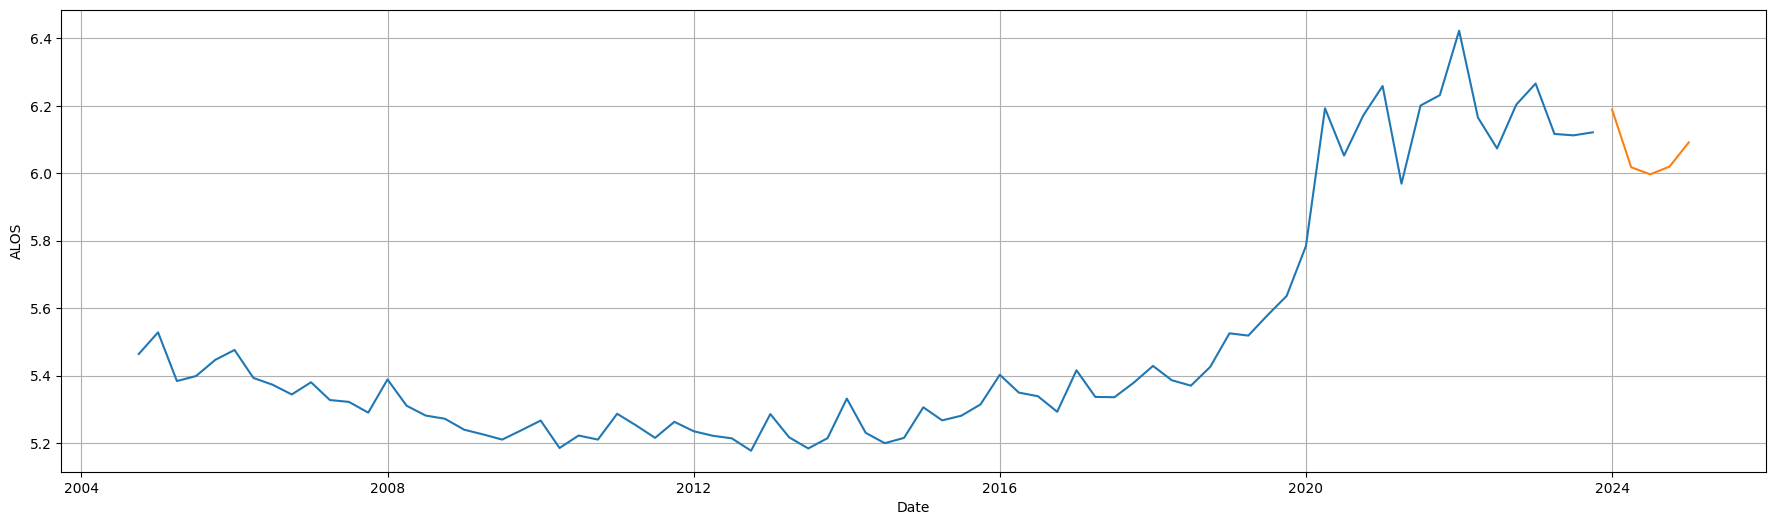

In [111]:
plt.figure(figsize=(22, 6))
plt.plot(tr_df.index, tr_df['ALOS'])
plt.plot(ts_df.index, ts_df['ALOS'])
plt.xlabel('Date')
plt.ylabel('ALOS')
plt.grid(True)
plt.show()

* <font color="green"> Our dataset seems to have upper trend and some limited sign seasonality

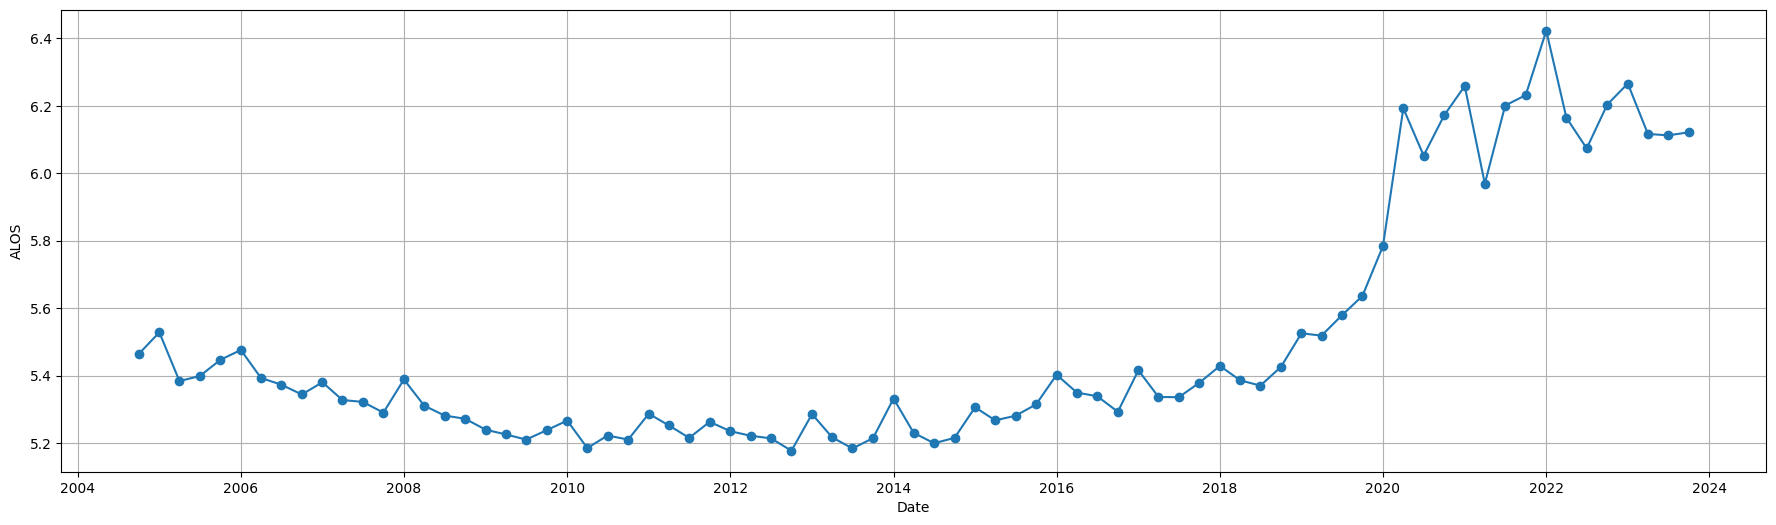

In [112]:
plt.figure(figsize=(22, 6))
plt.plot(tr_df.index, tr_df['ALOS'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('ALOS')
plt.grid(True)
plt.show()

#### **Now, as we have observed the presene of trend and seasonality, lets deep dive into the dataset and look into the components in detail**

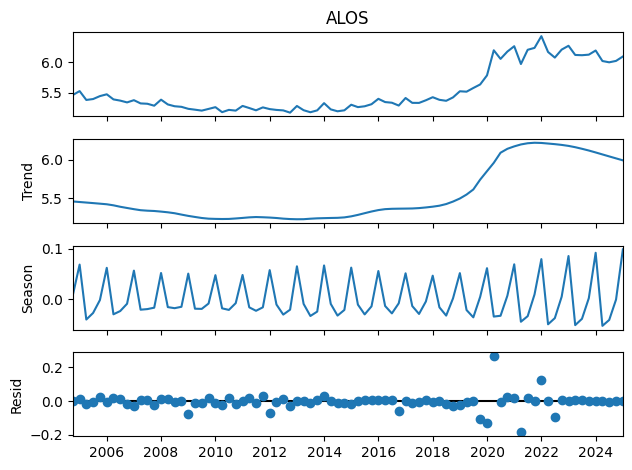

In [113]:
from statsmodels.tsa.seasonal import STL

stl = STL(df['ALOS'], period=4, robust=True)
result = stl.fit()
result.plot()
plt.show()

#### **So, the presence of both the trend and seasonality component, confirms that our data is non-stationary, but again to confirm further we apply some other techniques like ACF plot and ADF test**

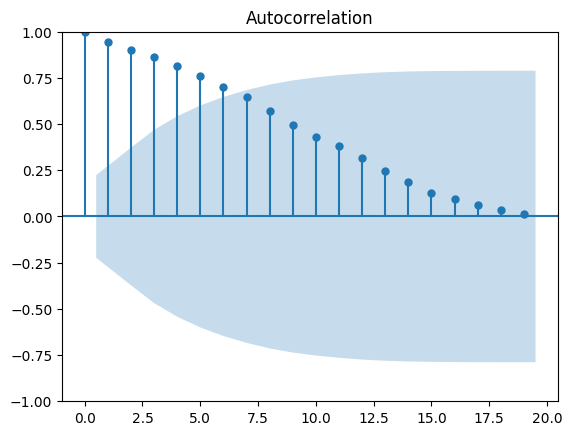

In [114]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(tr_df['ALOS'])
plt.show()

* <font color="green"> This steady decaying of the spikes confirms that our dataset is non-stationary

In [115]:
from statsmodels.tsa.stattools import adfuller

adf_test=adfuller(tr_df['ALOS'])
print('ADF_statistic:', adf_test[0])
print('p-value:', adf_test[1])

ADF_statistic: -0.08520290304448806
p-value: 0.9508925819953727


* <font color="green"> If p-value is greater the 0.05 then it is considered that the dataset is probably non-stationary

#### **Now, to remove seasonality and trend component and to make our dataset stationary, we need to perform 'trend differencing' and 'seasonal differencing'**

In [116]:
tr_df['non_st']=tr_df['ALOS'].diff(periods=1).diff(periods=4)

#### **We have removed the trend and seasonality component, now lets look into STL decomposition, acf plot annd ADF test once again and lets plot acf and pacf test to identify parameters for our model; since we have noticed the presence of both trend and seasonal component, lets apply Seasonal ARIMA (SARIMA) to our dataset**

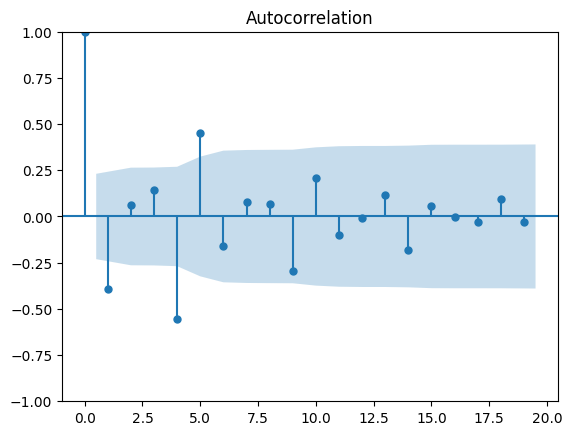

In [117]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(tr_df['non_st'].dropna())
plt.show()

* <font color="green"> We can observe that there is no similar movement of spikes as before for the above plot

In [118]:
from statsmodels.tsa.stattools import adfuller

adf_test=adfuller(tr_df['non_st'].dropna())
print('ADF_statistic:', adf_test[0])
print('p-value:', adf_test[1])

ADF_statistic: -3.748717649303409
p-value: 0.0034778052989627006


* <font color="green"> Also, our p-value is less then 0.05 which confirms that our dataset has been transformed and it is non-stationary for now

#### **Now, as we have confirmed our dataset is free of trend and seasonal component and now we can draw acf and pacf plot to identify parametrs (p, d, q, P, D, Q and S) for our SARIMA model**

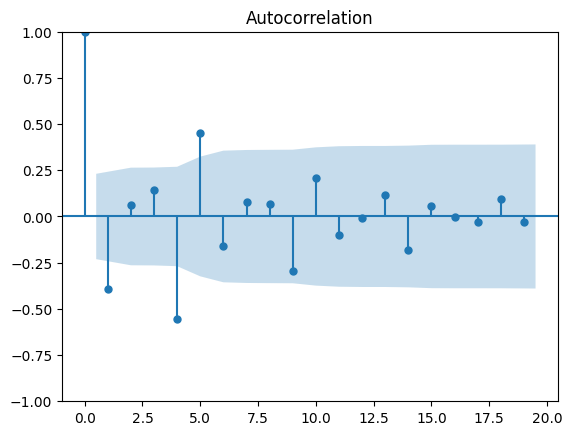

In [119]:
plot_acf(tr_df['non_st'].dropna())
plt.show()

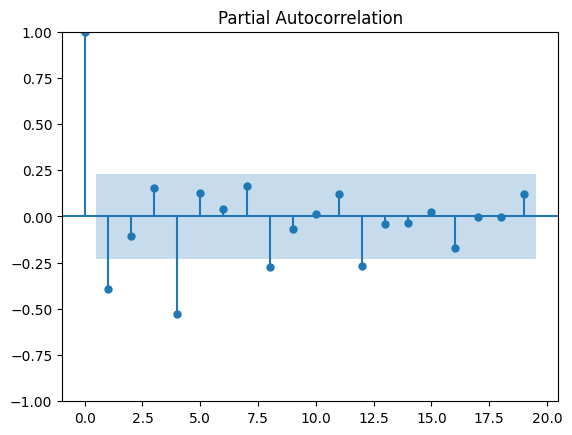

In [120]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(tr_df['non_st'].dropna())
plt.show()



* <font color="green"> We have got quarterly dataset so we can consider s=4 also the first spike at 'lag 1' in both acf and pacf plot shows negative corelation, no significant spike after s and we have applied trend and seasonal differencing 1 time so now we have </font>

      p=1
      d=1
      q=0
      P=1
      D=1
      Q=0 &
      S=4





#### **Now, lets drop the trasformed stationary column and apply the findings alog with model to the original dataset, to train our SARIMA model**

In [121]:
trr_df=tr_df.drop('non_st', axis=1)
trr_df

,ALOS
date,
2004-10-01,5.464011
2005-01-01,5.528190
2005-04-01,5.383719
2005-07-01,5.398523
2005-10-01,5.446533
...,...
2022-10-01,6.203864
2023-01-01,6.266268
2023-04-01,6.116761


### **Model Training & Evaluation**
---

#### **Lets input the parametrs and train our model**

In [122]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model=SARIMAX(trr_df, order=(1,1,0), seasonal_order=(1,1,0,4), enforce_stationarity=False, enforse_invertiblity=False)
results=model.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                              ALOS   No. Observations:                   77
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 4)   Log Likelihood                  55.901
Date:                           Tue, 09 Sep 2025   AIC                           -105.801
Time:                                   13:07:04   BIC                            -99.187
Sample:                               10-01-2004   HQIC                          -103.184
                                    - 10-01-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2785      0.109     -2.564      0.010      -0.491      -0.066
ar.S.L4       -0.5240      0.038    -13.926

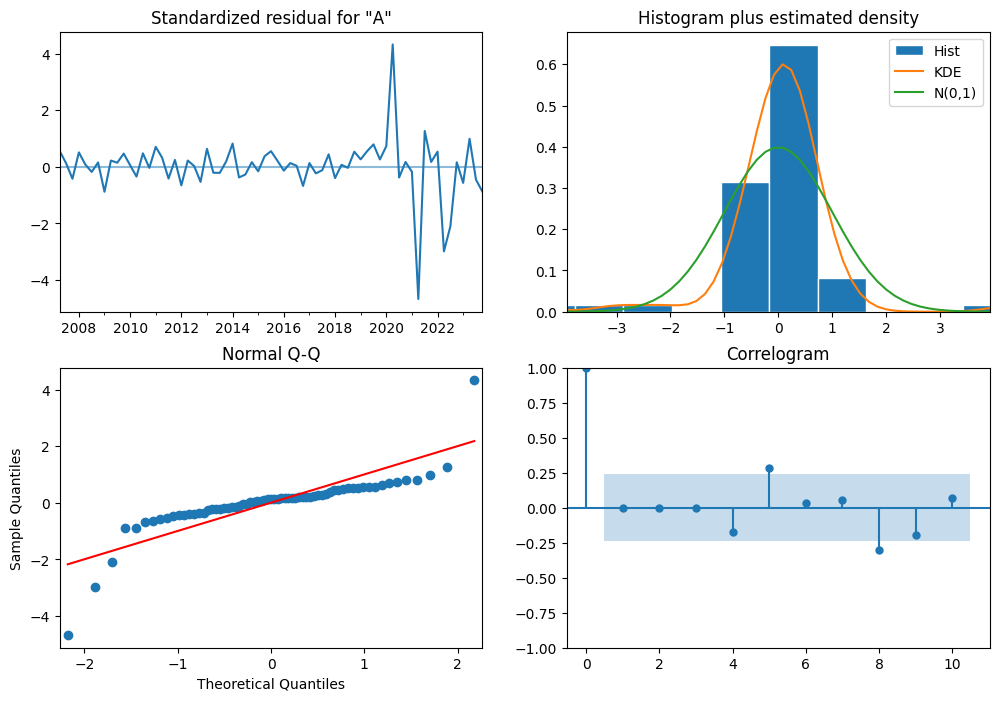

In [123]:
results.plot_diagnostics(figsize=(12, 8))
plt.show()

1. <font color="green">**Standardized Residual Plot :** Residuals fluctuate randomly around 0 without obvious trend or pattern suggesting that the model is capturing the systematic structure. However, there are some disturbance indicating some outliers or events not explained by the model </font>
2. <font color="green">**Histogram + KDE :** The KDE roughly resembles a normal distribution centered around 0 but appears slightly skewed and possibly with heavier tails </font>
3. <font color="green">**Normal Q-Q Plot :** Most points fall close to the red line but deviations at both tails, indicating some non-normality, likely due to outliers or extreme events </font>
4. <font color="green">**Correlogram (Residual ACF Plot) :** Slight significant spike at lag 5 and no significant autocorrelation at most lags


#### **Lets prepare our test dataset for prediction**

In [124]:
tss_df=ts_df.drop('ALOS', axis=1)
tss_df

""
date
2024-01-01
2024-04-01
2024-07-01
2024-10-01
2025-01-01


In [125]:
prediction=results.get_prediction(start=tss_df.index[0], end=tss_df.index[-1], dynamic=False)
forecast=prediction.predicted_mean
forecast

,predicted_mean
2024-01-01,6.270642
2024-04-01,6.059049
2024-07-01,6.010671
2024-10-01,6.082677
2025-01-01,6.186456


#### **Predicted values are quite close to the actual result, Lets visualize the values to get a visual understanding**

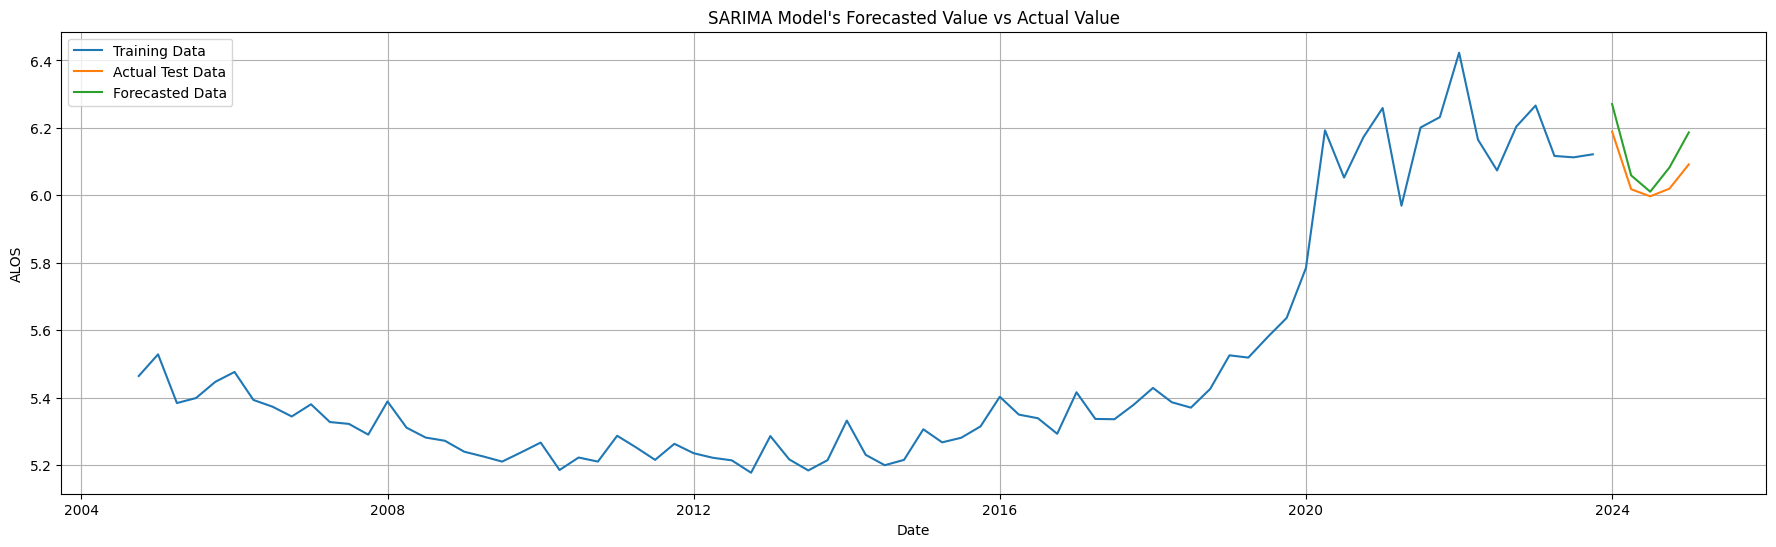

In [126]:
plt.figure(figsize=(22, 6))
plt.plot(trr_df.index, trr_df['ALOS'], label='Training Data')
plt.plot(ts_df.index, ts_df['ALOS'], label='Actual Test Data')
plt.plot(forecast.index, forecast, label='Forecasted Data')
plt.title("SARIMA Model's Forecasted Value vs Actual Value")
plt.xlabel('Date')
plt.ylabel('ALOS')
plt.legend()
plt.grid(True)
plt.show()

In [127]:
final_forecast = results.get_forecast(steps=4)
forecast_ci = final_forecast.conf_int()

print("Forecast for the next 4 quarters:")
print(final_forecast.predicted_mean)
print("\nConfidence Intervals:")
print(forecast_ci)

Forecast for the next 4 quarters:
2024-01-01    6.270642
2024-04-01    6.059049
2024-07-01    6.010671
2024-10-01    6.082677
Freq: QS-OCT, Name: predicted_mean, dtype: float64

Confidence Intervals:
            lower ALOS  upper ALOS
2024-01-01    6.064749    6.476535
2024-04-01    5.805154    6.312943
2024-07-01    5.708129    6.313212
2024-10-01    5.740395    6.424959


#### **Although our model shows good output, close to real value. But it is necesarry to measure the erors when considering practical implementation**

In [128]:
from statsmodels.tools.eval_measures import rmse, meanabs

rmse_value=rmse(ts_df['ALOS'], forecast)
mae_value=meanabs(ts_df['ALOS'], forecast)
mape_value=np.mean(np.abs((ts_df['ALOS'] - forecast) / ts_df['ALOS'])) * 100
print('RMSE:', rmse_value)
print('MAE:', mae_value)
print('MAPE:', mape_value)

RMSE: 0.06550883340793635
MAE: 0.05878963785760831
MAPE: 0.9656932612937277


* **The SARIMA model demonstrates strong predictive performance for estimating ALOS in U.S. hospitals**
* **Residuals showed no significant autocorrelation, confirming good model fit, Histogram and Q-Q plots indicated near-normal residual distribution, with minor skewness due to outliers**
* **Predicted ALOS for upcoming quarters ranged between 6.01 to 6.27 days, with tight confidence intervals**
* **RMSE (Root Mean Squared Error): 0.0655 Indicates low average deviation between predicted and actual ALOS**
* **MAE (Mean Absolute Error): 0.0588 Shows consistent accuracy across forecasted quarters**
* **MAPE (Mean Absolute Percentage Error): 0.97% Reflects excellent percentage-based precision, well below typical thresholds**
* **The model offers reliable short-term forecasts for hospital administrators and supports strategic planning in areas like bed management, staffing, and discharge protocols**